In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random
import cv2
import warnings
import math
from tabulate import tabulate
from skimage.morphology import skeletonize
from tqdm import tqdm
from skimage import io, color, morphology
from scipy.ndimage import distance_transform_edt
import scipy.ndimage.morphology
import scipy.io as sio
sys.path.append('../')  # Adds the root directory to Python's module search path
from MLVcode.load_mat import load_mat
from MLVcode.unique import unique1D, unique2D, unique3D

In [3]:
data_keys = {'originalImage','imsize', 'lineMethod', 'numContours',                
            'contours', 'orientations', 'lengths',   'contourLengths',             
            'curvatures', 'junctions', 'parallelism',  'parallelismMeans',           
            'parallelism_allX', 'parallelism_allY','parallelism_allScores', 
            'parallelismBins', 'parallelismHistograms', 'parallelismNormHistograms',  
            'parallelismSumHistogram', 'parallelismNormSumHistogram',
            'separation', 'separationMeans', 'separation_allX',  'separation_allY',            
            'separation_allScores', 'separationBins',             
            'separationHistograms', 'separationNormHistograms',   
            'separationSumHistogram', 'separationNormSumHistogram', 
            'mirror', 'mirrorMeans', 'mirror_allX', 'mirror_allY',                
            'mirror_allScores', 'mirrorBins', 'mirrorHistograms', 
            'mirrorNormHistograms', 'mirrorSumHistogram', 'mirrorNormSumHistogram'}

# filename='../dataSets/TorontoScenes/mountains_vecLD.mat'
filename = '../dataSets/TorontoScenes/mountains_vecLD.mat'
data = load_mat(filename)

Name:  ['mountains_00198.jpg']
Shape of contour:  (1, 34)
Size of image:  [[800 600]]
(1440000,)
+----------+-----------------+
|   Unique |           Count |
|----------+-----------------|
|        0 | 15732           |
|        1 |     1.42427e+06 |
+----------+-----------------+
Unique values in the 3D array:  2 the values are:
 [0 1]
Counts of unique values in the 3D array:  2 the counts are: 
 [  15732 1424268]


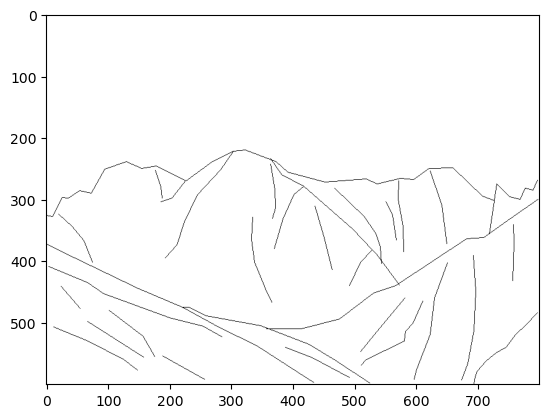

In [5]:
cute = {}
# Assign the data to the dictionary and define them with empty value
for key in data_keys:
    cute[key] = data['vecLD'][key][0][10]
print("Name: ", cute['originalImage'])
print("Shape of contour: ", cute['contours'].shape)
print("Size of image: ", cute['imsize'])
# Load imgLD.mat in same folder
imgLD = load_mat('imgLD.mat')
# Convert 1s to 255s
# make a copy of the array
temp = imgLD['imgLD'].copy()
# Replace 1s with 255s
temp[temp==1] = 255
uni, count = unique3D(imgLD['imgLD'])
# Print the unique values and their counts
print(tabulate({'Unique':uni, 'Count':count}, headers='keys', tablefmt='psql'))
print("Unique values in the 3D array: ", uni.shape[0], "the values are:\n", uni)
print("Counts of unique values in the 3D array: ", count.shape[0], "the counts are: \n", count)
plt.imshow(temp)
plt.show()

In [10]:
from MLVcode.bwdist import bwdist
from MLVcode.is_outer_border_point import is_outer_border_point
from MLVcode.getOuterBoundary import getOuterBoundary
from MLVcode.computeGradientVectorField import computeGradientVectorField
from MLVcode.sample_sphere_2D import sample_sphere_2D
from MLVcode.computeAOF import computeAOF
from MLVcode.extract2DSkeletonFromBinaryImage import extract2DSkeletonFromBinaryImage
from MLVcode.computeMAT import computeMAT

Shape of image:  (600, 800, 3)


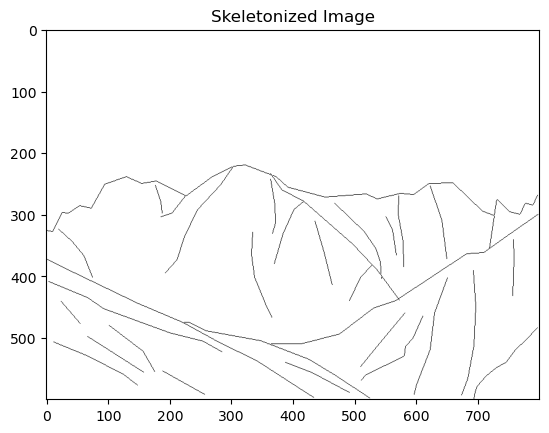

In [12]:
# imgLD['imgLD']
test = imgLD['imgLD'].copy()
# Print the shape of the image
print("Shape of image: ", test.shape)
# make it 2D instead of 3D
test = test[:,:,0]
# Skeletonize the image
test = ~test.astype(bool)
test = skeletonize(test, method='lee').astype(np.uint8)
# Invert the image
test = cv2.bitwise_not(test)
# Invert the image using bitwise_not
plt.imshow(test, cmap='gray')
# title
plt.title("Skeletonized Image")
plt.show()

Plotting the skeleton ...


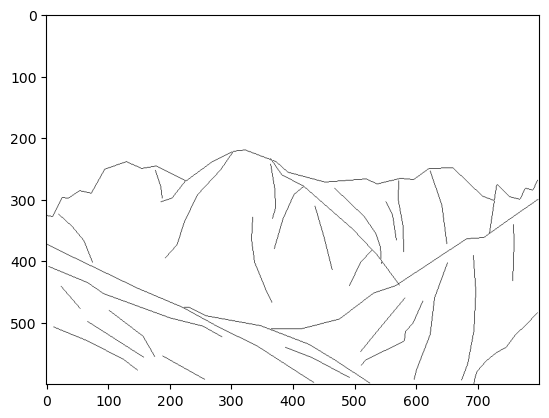

Skeleton is plotted.
Area threshold is:  20
Distance function and gradient vector field is being computed ...

Result Size:  (480000, 2)
Counter:  5218


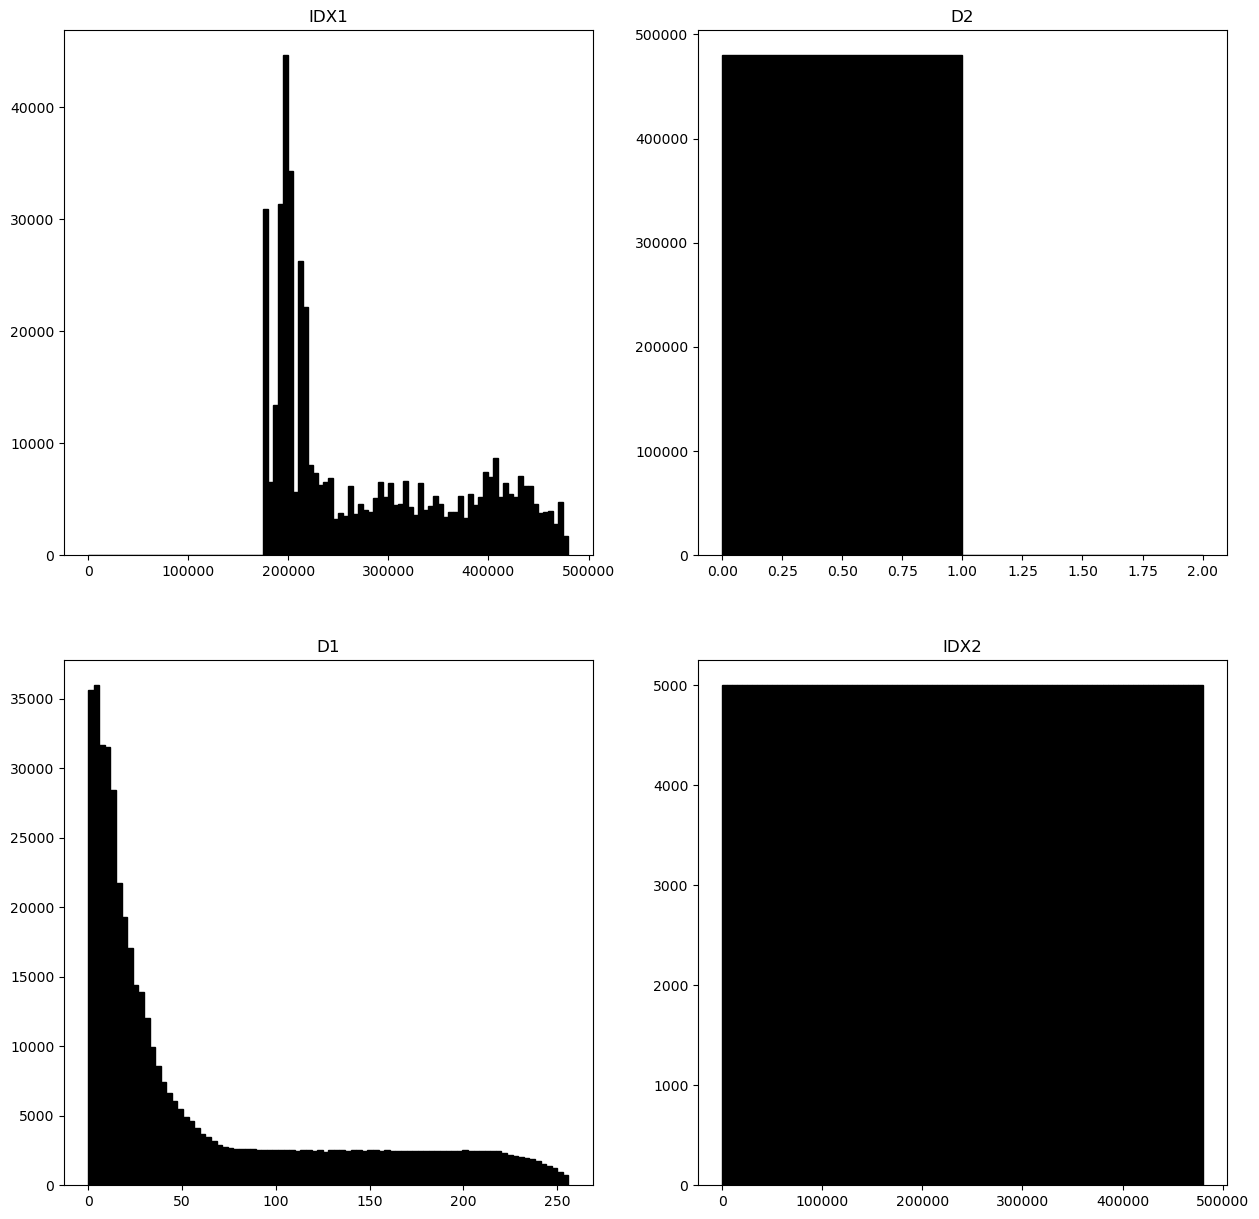

Average outward flux is being computed ...



100%|██████████| 600/600 [01:54<00:00,  5.24it/s]


Average outward flux is computed.

Flux Image: 
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.11268942 -0.11284078 ... -0.11214953  0.
   0.        ]]


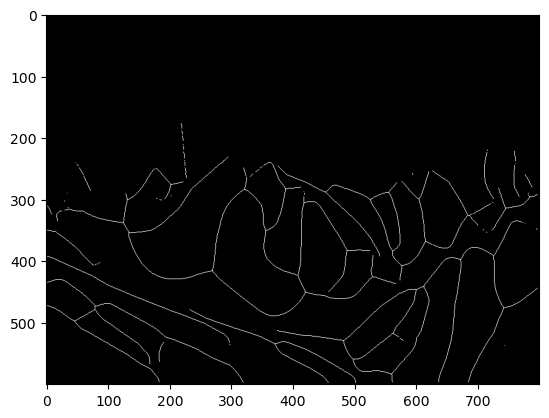

In [14]:
# Compute Medial Axis
mat, fluxImage, skeletonImage, distImage = computeMAT(imgLD['imgLD'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


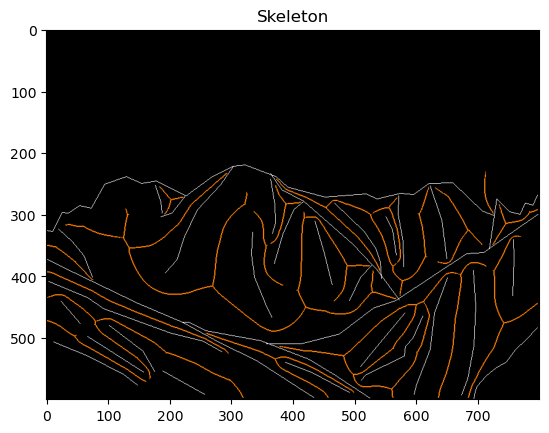

In [16]:
orange_skeleton = np.stack([skeletonImage, 0.5 * skeletonImage, np.zeros_like(skeletonImage)], axis=-1)
# Plot the image
plt.figure()
invert = ~(imgLD['imgLD']*255)
invert = invert+orange_skeleton
plt.imshow(invert, cmap='gray')
plt.title('Skeleton')
plt.show()

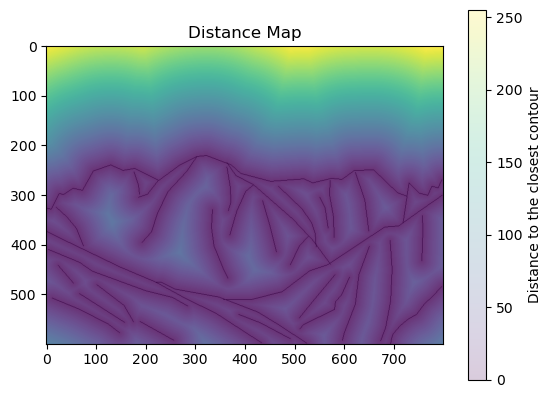

In [30]:
plt.figure()
plt.imshow(distImage)
plt.imshow((imgLD['imgLD']*255), alpha=0.2)
# Add title
plt.title("Distance Map")
# Add title for colorbar
cbar = plt.colorbar()  # Create a colorbar and keep a reference to the Colorbar object
cbar.set_label("Distance to the closest contour")
cbar.mappable.set_cmap('viridis')
plt.show()

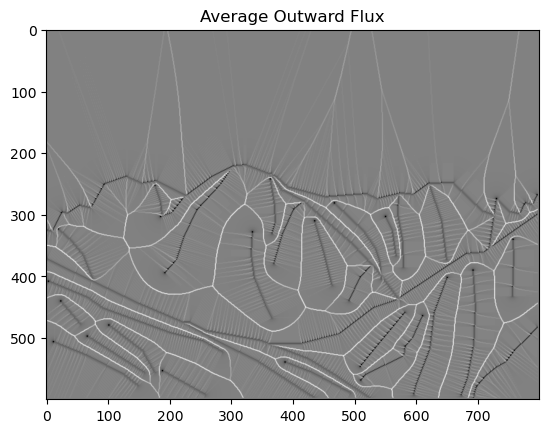

In [32]:
# load_mat('fluxImage.mat')['fluxImage']
plt.figure()
plt.imshow(load_mat('fluxImage.mat')['fluxImage'], cmap='gray')
plt.imshow(~(imgLD['imgLD']*255), alpha=0.01, cmap='Reds')
# Add title
plt.title("Average Outward Flux")
plt.show()

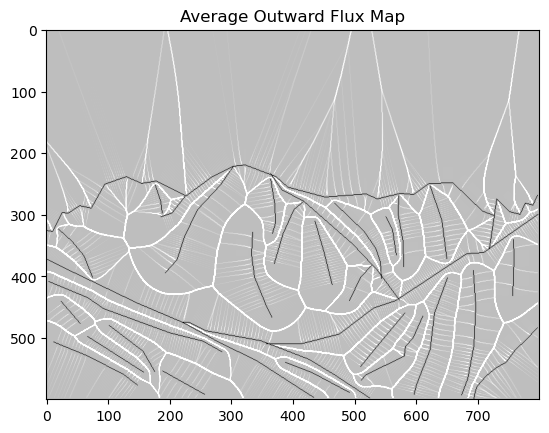

In [36]:
# Making it look better
plt.figure()
from matplotlib.colors import LinearSegmentedColormap
bw_cmap = LinearSegmentedColormap.from_list('bw_cmap', [(0, 'black'), (1, 'white')])
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, (1, 0, 0, 0)), (1, (1, 0, 0, 1))])
fluxImage = load_mat('fluxImage.mat')['fluxImage']
img_LD = imgLD['imgLD']


plt.imshow(fluxImage, cmap=bw_cmap, vmin=0, vmax=10, alpha=1.0)
plt.imshow((img_LD*255),cmap=cmap, vmin=0, vmax=10, alpha=0.75)
plt.title("Average Outward Flux Map")
plt.show()